Created by Mark Crandell with data from the EIA. Data accessed for free through Statistica.com
This Jupyter Notebook analyzes the composition of the US electrical grid broken down by production source.
Projections extend through 2050.

In [ ]:
import pandas as pd                       # Begin by importing the necessary libraries
import numpy as np
from matplotlib import pyplot as plt

font = {'family' : 'normal',              # I also tweek the font to make plots easier to read
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

To start, I take in data of US energy consumption. These data show US purchased electricity (i.e. all energy purchased from the grid which accounts for >99% of all electrical energy consumption. The csv I read in is from a single row of the broad EIA spreadsheet. 

The data needed some cleaning. First of all, it was imported as a row, but I needed to transpose it as a column. Secondly, the data included unneccessary tabs and sapces which made the data difficult to access, so I deleted these. Some data were given as strings rather than integers, so I needed to convert these to ints. Lastly, the data were given in quadrillion BTU. I needed to convert it to TWh to match the data given for production.

In [102]:
### Importing Electric Energy Consumption Data ###
consumption = pd.read_csv('consumption.csv',index_col = 0, usecols = range(31))    # Import consumption data
consumption = consumption.T                                                        # Transpose the data
consumption.columns = consumption.columns.str.replace(' ','')                      # Delete unnecessary spaces
consumption['Total TWh'] = consumption['PurchasedElectricity'] * 293.07            # Adding a TWh column from BTU data
consumption.index = consumption.index.map(int)                                     # Converting all numbers to ints 
# consumption.head()                                         ### Uncommenting this line will show a header of the data ###

This is where most of the data are. These data show the breakdown of US energy production by major production type. First I read in the data. Why limit the range to 31 columns? Because the last column describes percent change, a number which was unimportant to my analysis. The data is first cleaned in a manor very similar to the process for consumption data.

In [104]:
### Importing Energy Supply Data ###
data = pd.read_csv('elec.csv',index_col = 0,usecols = range(31)) # Reading Data from the CSV file of data. Limiting range to just first 31 cols

                                                                 # Cleaning data values from str to int
data.replace(',','', regex=True, inplace=True)                   # Some numbers have ','s. This code removes those 
c = data.select_dtypes(object).columns                           # This selects all of the data which was imported as a string
data[c] = data[c].apply(pd.to_numeric,errors='coerce')           # This converts all string data to numeric data
   
                                                                 # Making the column names to be the respective years 
data.columns = list(range(2021,2051))                            # (these columns will be transposed to row indeces)
    
data = data.T                                                    # Transposing for easier plotting
    
data.columns = data.columns.str.replace(' ','')                  # Column titles had random spaces, this code removes those 
data.index.name = 'Year'                                         # Adding a title to the index column

# data.head()                                                  ### Uncommenting this line will show a header of the data ###

I'm mostly interested in the breakdown between renewables and other sources. The breakdown of all the different fossil based sources is a little overdetailed for my analysis, so I add a column which totals the three major fossil based sources. Of course, the breakdown among fossil fuels is also very important because natural gas has significantly less emissions than coal.

In [106]:
# Summing the coal, petroleum, and natural gas production totals into a column titled "Fossil Fuels Based"
data['Fossil Fuels Based'] = data.loc[:,['Coal','Petroleum','NaturalGas']].sum(axis = 1) 
# data.head()                                                 ### Uncommenting this line will show a header of the data ###                           

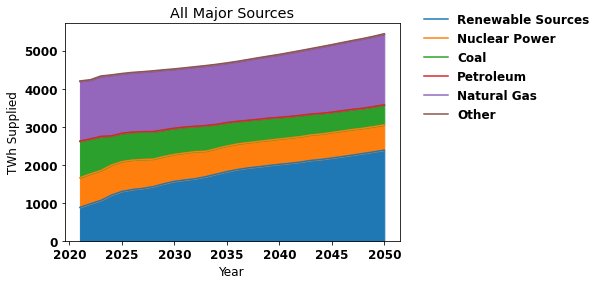

In [90]:
# Plotting Data by all major sources

data.plot.area(y = ['RenewableSources5,9/','NuclearPower','Coal','Petroleum','NaturalGas','Other11/'],use_index = True)
plt.title('All Major Sources')
plt.xlabel('Year')
plt.ylabel('TWh Supplied')
plt.legend(['Renewable Sources','Nuclear Power','Coal','Petroleum','Natural Gas','Other'],loc = 'lower right', frameon = False, bbox_to_anchor = (1.6,0.5))

Above, you see the grid makeup over time by majro production source. This is mostly very simple plotting. You can see where I created the legend and moved it outside of the axis frame to make it easier to read.

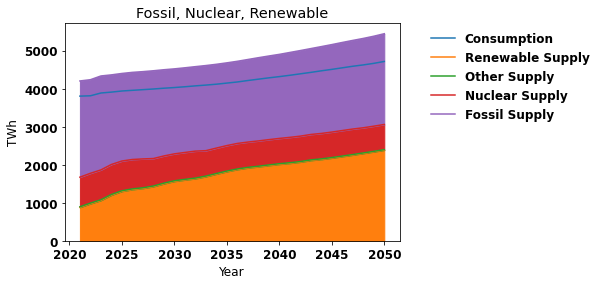

In [107]:
# Plotting data with fossil fuels combined
ax = consumption.plot(y = 'Total TWh',use_index = True)
data.plot.area(y = ['RenewableSources5,9/','Other11/','NuclearPower','Fossil Fuels Based'],use_index = True, ax = ax)
plt.title('Fossil, Nuclear, Renewable')
plt.xlabel('Year')
plt.ylabel('TWh Supplied')
plt.legend(['Consumption','Renewable Supply','Other Supply','Nuclear Supply','Fossil Supply'],loc = 'lower right', frameon = False, bbox_to_anchor = (1.6,0.5))

Above, you see the same plot as the previous except the fossil fuels are bundled into a single category. I also include the line for energy consumption in this graph. That information is pretty interesting. What can we tell? Well, renewable energy production is expected to more than double in the next 30 years. That sounds great, but at the same time, our reliance on fossil fuels remains the same. This is because the total energy need is increaing over the period. Reliance on nuclear energy stays relatively constant throughout the period.

You might think that energy consumption should equal the amount of energy supplied. Three reasons why this is not the case are as follows. 1.) The US exports some energy to Canada and Mexico. 2.) Some energy is lost before it reaches the grid in the transformers, inverters, and other medium voltage components. 3.) Energy is lost even after it reaches the grid via transmission line losses.

You might also notice that the gap between energy consumption and energy produced increases througout the period. This made me curious as to which of the reasons I listed above could be the cause of this. I have limited data to figure this out. In the cell that follows, I look at whether the percent of electricity making it to the grid is changing over time.

Text(0, 0.5, 'Energy produced / energy reaching the grid')

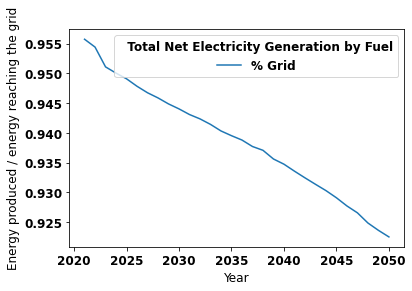

In [111]:
# Figuring out what % of net energy generated makes it to the grid
data['% Grid'] = data['NetGenerationtotheGrid'] / data['TotalNetElectricityGeneration']
data['% Renewable'] = data['RenewableSources5,9/'] / data['TotalNetElectricityGeneration']
data.plot(y = ['% Grid'])
plt.ylabel('Energy produced / energy reaching the grid')
# This graph shows that the fraction of energy produced that makes it to the grid is expected to decrease at a steady
# rate from 2020 to 2050

Interestingly, you can see that the fraction of energy produced that reaches the grid steadily decreases througout the window. Why? Well, I can't say for certain, but my strong suspicion is that the rise in renewable generation is the primary contributor. Intermittent energy sources such as solar and wind are not always able to export their energy to the grid. This is because periods of peak renewable energy production (e.g. high sunshine or hich wind) do not always align with the periods of peak energy demand. Energy storage is a commonly sought solution to eliminate renewable energy curtailment. These data may suggest that more energy storage is needed to augment the increase in renewable energy production.

Next, I complete the same calculations listed above except I multiply all of the values by the fraction of energy that reaches the grid. The data that follow are virtually identical to the data shown above; however, they show the fraction of energy that reaches the grid by each source rather than the fraction of energy that is produced by each source.

In [95]:
# Here I am creating a dictionary containing the quantity of energy sent to the grid by source
# I do this by copying the previous dictionary of production and multiplying it by the % of energy that reaches the grid
# This assmes that all energy types have the same fraction that reachest the grid
# As I mentioned earlier, this is likely not true; unfortunately, I don't really have data to do this any other way

to_grid = data[['RenewableSources5,9/','Other11/','NuclearPower','Fossil Fuels Based']].multiply(data['% Grid'],axis = 'index')
to_grid.columns = ['Renewable', 'Other', 'Nuclear', 'Fossil']
to_grid['Total'] = to_grid.loc[:,['Renewable','Other','Nuclear','Fossil']].sum(axis=1)
to_grid['Consumption'] = consumption['Total TWh']
# to_grid.head()                                       ### Uncomment to print a header of the dataframe ###

,Renewable,Other,Nuclear,Fossil,Total,Consumption
Year,,,,,,
2021,840.100642,15.291934,743.570307,2418.037116,4017.000000,3804.0486
2022,930.566706,15.270838,748.271074,2348.845809,4042.954427,3812.8407
2023,1010.063668,16.168627,746.610150,2349.206459,4122.048904,3886.1082
2024,1141.005041,16.150779,749.586159,2238.307974,4145.049954,3909.5538
2025,1232.869091,16.134545,742.189091,2184.807273,4176.000000,3938.8608


Next, I generate a plot simlar to the one above that shows the quanitity of energy generated from each source through 2050.

What we can see here is that fossil fuels still represent a significant portion of the grid composition through 2050.


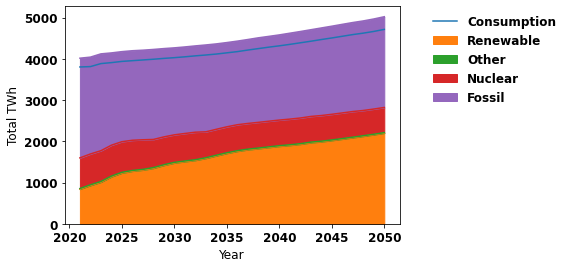

In [96]:
ax = to_grid.plot(y = 'Consumption', use_index = True)
to_grid.plot.area(y = ['Renewable','Other','Nuclear','Fossil'], ax = ax, use_index = True)
plt.ylabel('Total TWh')
plt.legend(loc = 'lower right', frameon = False, bbox_to_anchor = (1.5,0.5))

print('What we can see here is that fossil fuels still represent a significant portion of the grid composition through 2050.')

The plot above shows the total energy produced by category through 2050. You may be curious how each of these sources factors into the total on a percent basis. That's what I set out to determine next. The most striking difference between the two plots is the trajectory of renewable penetration in the total supply. In terms of total production, renewables show a steady increase in generation capacity; however, the story is different on a percent basis. While renewables still show continued growth in the total grid composition, the rate of the rate of this growth (the second derivative) is negative. Based on the EIA's data, it appears that renewables asymptotically approach around 45% penetration in the total market.

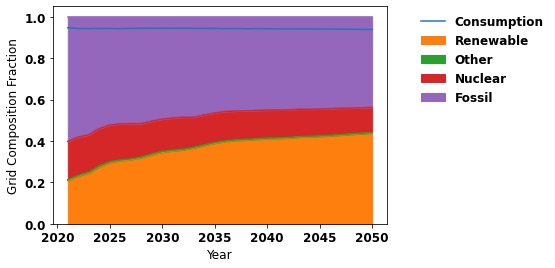

In [97]:
grid_fraction = to_grid.iloc[:,:].div(to_grid.Total, axis=0)

ax = grid_fraction.plot(y = 'Consumption', use_index = True)
grid_fraction.plot.area(y = ['Renewable','Other','Nuclear','Fossil'], ax = ax, use_index = True)
plt.ylabel('Grid Composition Fraction')
plt.legend(loc = 'lower right', frameon = False, bbox_to_anchor = (1.5,0.5))


Next, I thought it would be nice to put these two plots next to each other for easy comparison.

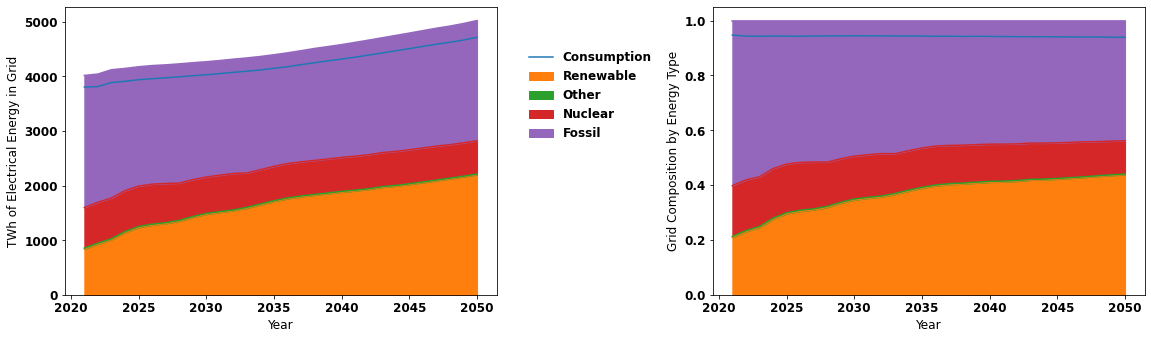

In [101]:
#create subplot figure with having two side by side plots
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

to_grid.plot(y = 'Consumption', use_index = True, ax = ax1, legend = False)
to_grid.plot.area(y = ['Renewable','Other','Nuclear','Fossil'], use_index = True, ax = ax1, legend = False)

grid_fraction.plot(y = 'Consumption', use_index = True, ax = ax2, legend = False)
grid_fraction.plot.area(y = ['Renewable','Other','Nuclear','Fossil'], ax = ax2, use_index = True, legend = False)
plt.legend(loc = 'lower left', frameon = False, bbox_to_anchor = (-0.45,0.5))
ax1.set_ylabel('TWh of Electrical Energy in Grid')
ax2.set_ylabel('Grid Composition by Energy Type')
plt.subplots_adjust(left=0.0,
                    bottom=0.1, 
                    right=1.0, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)
plt.show()

I was curious whether the % of energy that reaches the grid is correlated with the grid composition of renewable energy. The plot below shows there is certainly a positive correlation between the composition of renewables and the fraction of energy lost prior to grid injection. There are not enough data to determine whether this relationship is causal or not. It could be that a third factor is driving both of these factors.

Based on the plot below, it appears that the fraction of electricity injected to the grid decreases as renewables achieve a greater composition of the grid. This is merely a correlation though.


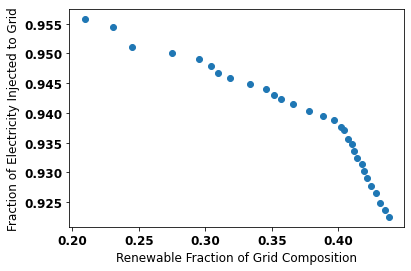

In [94]:
# Figuring out if there is a relationship between the amount of energy that makes it to the grid 
# and the amount of energy that comes from renewable sources
# there does not seem to be a clear relationship

plt.scatter(data['% Renewable'], data['% Grid'])
plt.ylabel('Fraction of Electricity Injected to Grid')
plt.xlabel('Renewable Fraction of Grid Composition')

print('Based on the plot below, it appears that the fraction of electricity injected to the grid decreases as renewables achieve a greater composition of the grid. This is merely a correlation though.')

(0.0, 5100.0)

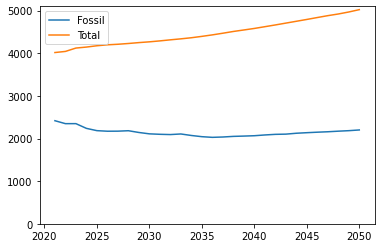

In [119]:
to_grid.plot(y= ['Fossil','Total'], use_index = True)
plt.ylim([0, 5100])